In [1]:
import numpy as np
import pandas as pd

from skimage import io
from skimage import color
import skimage.measure
import cv2
from IPython.display import SVG

import face_recognition

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import tensorflow as tf
from keras import layers
import keras
from keras.utils import plot_model
from keras import backend as K

import random
import math
import os

In [2]:
tf.get_logger().setLevel('ERROR')

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## autoencoder

In [72]:
def encoder(t,b,l,r):
    tf.keras.backend.clear_session() #prevent high mem usage
    
    n,m=b-t,r-l
    
    # read faces from files
    
    #blank image here (since we will have to process blank images later)
    faces=[np.ones(shape=(n*m,))*0.5]
    
    for file in os.listdir("faces"):
        face=mpimg.imread('faces/'+file)[:,:,0]
        face=cv2.resize(face,(96,96))
        face=face[t:b,l:r]
        face=face/256 #compress into [0,1]
        face+=0.5-face.mean()
        faces.append(face.reshape(-1)) #flatten
    
    faces=np.array(faces)
        
    #build autoencoder
    #it is actually just a single dense layer
    
    input_encoder=layers.Input((n*m,))
    
    #encoder
    encoded=layers.Dense(16,activation='sigmoid')(input_encoder) #latent space of 4

    encoder=keras.Model(
        inputs=[input_encoder],
        outputs=[encoded],
    )
    
    #decoder
    decoded=layers.Dense(n*m,activation='sigmoid')(encoded)

    train=keras.Model(
        inputs=[input_encoder],
        outputs=[decoded],
    )
    
    #train the autoencoder
    train.compile(
      optimizer="adam",
      loss="mean_squared_error",
    )
    
    #do 100 epochs
    train.fit(faces,faces,validation_split=0.2,epochs=20,batch_size=8,steps_per_epoch=1000)
    
    #display some examples of autoencoder
    fig,axs=plt.subplots(6,17,figsize=(17,6))
    
    for x in axs.ravel():
        x.axis('off')

    pred=train.predict(faces[:17])
    pred2=encoder.predict(faces[:17])

    for i in range(17):
        axs[0,i].imshow(faces[i].reshape(n,m)) #in
        axs[2,i].imshow(pred[i].reshape(n,m)) #out
        axs[1,i].imshow(pred2[i].reshape(4,4)) #latent space
        
    #get decoder
    train.get_weights()
    
    inp=layers.Input(16)
    dense=layers.Dense(n*m)(inp)
    
    decoder=keras.Model(
        inputs=[inp],
        outputs=[dense],
    )
    decoder.set_weights(train.get_weights()[2:])
    
    temp=np.zeros(shape=(17,16))
    for i in range(16): temp[i+1][i]=1
    
    #show each parameter of the latent layer
    pred=decoder.predict(temp)
    
    for i in range(17):
        axs[5,i].imshow(pred[i].reshape(n,m)) #out
        axs[4,i].imshow(temp[i].reshape(4,4)) #latent space
    
    #return encoder and converter for use later
    return encoder,train

Epoch 1/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0244 - val_loss: 0.0154
Epoch 2/20
1000/1000 [==============================] - 1s 954us/step - loss: 0.0144 - val_loss: 0.0125
Epoch 3/20
1000/1000 [==============================] - 1s 966us/step - loss: 0.0121 - val_loss: 0.0110
Epoch 4/20
1000/1000 [==============================] - 1s 955us/step - loss: 0.0107 - val_loss: 0.0102
Epoch 5/20
1000/1000 [==============================] - 1s 966us/step - loss: 0.0101 - val_loss: 0.0096
Epoch 6/20
1000/1000 [==============================] - 1s 963us/step - loss: 0.0095 - val_loss: 0.0093
Epoch 7/20
1000/1000 [==============================] - 1s 924us/step - loss: 0.0091 - val_loss: 0.0088
Epoch 8/20
1000/1000 [==============================] - 1s 941us/step - loss: 0.0087 - val_loss: 0.0086
Epoch 9/20
1000/1000 [==============================] - 1s 959us/step - loss: 0.0084 - val_loss: 0.0085
Epoch 10/20
1000/1000 [==============================] - 1s 958us/

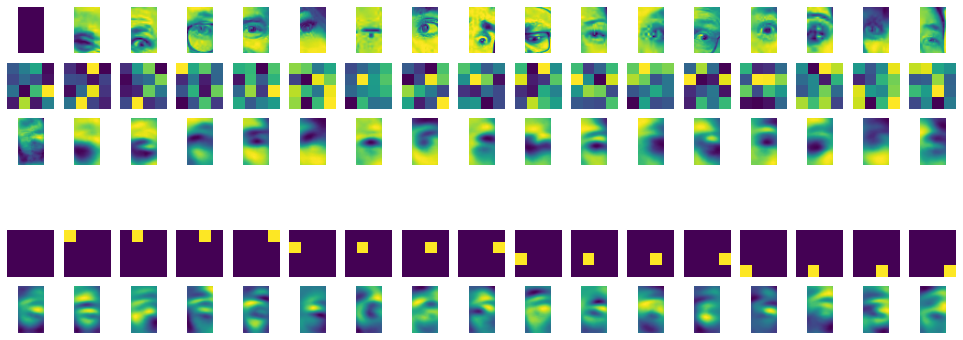

In [73]:
encode_eye,conv_eye=encoder(4,48,56,80)

Epoch 1/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0255 - val_loss: 0.0166
Epoch 2/20
1000/1000 [==============================] - 1s 959us/step - loss: 0.0164 - val_loss: 0.0144
Epoch 3/20
1000/1000 [==============================] - 1s 949us/step - loss: 0.0144 - val_loss: 0.0130
Epoch 4/20
1000/1000 [==============================] - 1s 935us/step - loss: 0.0130 - val_loss: 0.0121
Epoch 5/20
1000/1000 [==============================] - 1s 978us/step - loss: 0.0122 - val_loss: 0.0114
Epoch 6/20
1000/1000 [==============================] - 1s 939us/step - loss: 0.0115 - val_loss: 0.0110
Epoch 7/20
1000/1000 [==============================] - 1s 933us/step - loss: 0.0112 - val_loss: 0.0108
Epoch 8/20
1000/1000 [==============================] - 1s 942us/step - loss: 0.0109 - val_loss: 0.0107
Epoch 9/20
1000/1000 [==============================] - 1s 952us/step - loss: 0.0106 - val_loss: 0.0105
Epoch 10/20
1000/1000 [==============================] - 1s 929us/

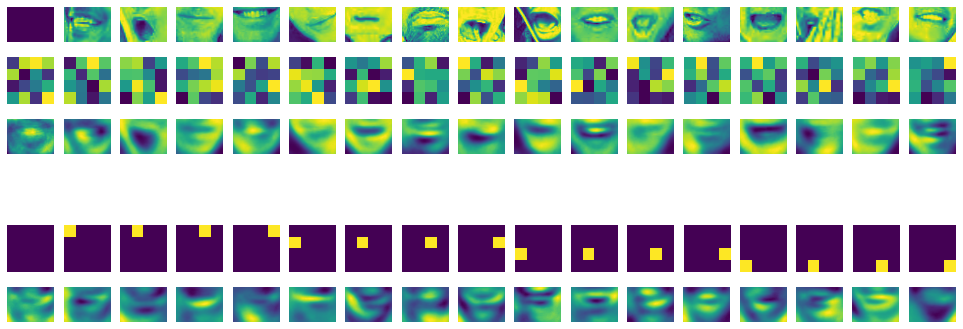

In [74]:
encode_mouth,conv_mouth=encoder(60,96,24,72)

In [8]:
def get_img(id):
    return mpimg.imread('thumbs/'+id+'.jpg')

In [9]:
def get_face(id,num):
    if (os.path.isfile('faces/'+id+'_'+str(num)+'.jpg')): return mpimg.imread('faces/'+id+'_'+str(num)+'.jpg')
    else: return np.ones((120,120,3),dtype='uint8')*128

In [38]:
def get_df(file):
    df=pd.read_csv(file,index_col=0)
    df=df.T
    df=df.reset_index(drop=True)
    
    return df

In [148]:
df=get_df('scraping youtube/metadata.csv')
df2=get_df('human acc/metadata.csv')
df3=get_df('scraping youtube/metadata_b0.csv')

In [149]:
print(df2[df2["id"]=="SlPhMPnQ58k"])
print(df3[df3["id"]=="kJQP7kiw5Fk"])
print(df3[df3["id"]=="R_oVq2hCy70"])

                                    title              views            likes  \
35   Maroon 5 - Memories (Official Video)  705,162,545 views  7,624,617 likes   
129  Maroon 5 - Memories (Official Video)  705,163,401 views  7,624,619 likes   

             dislikes                                               desc  \
35   170,752 dislikes  “Memories” is out now:\nhttps://smarturl.it/Me...   
129  170,752 dislikes  “Memories” is out now:\nhttps://smarturl.it/Me...   

              id clickbait  
35   SlPhMPnQ58k         0  
129  SlPhMPnQ58k         0  
                                       title                views  \
62   Luis Fonsi - Despacito ft. Daddy Yankee  7,293,692,975 views   
137  Luis Fonsi - Despacito ft. Daddy Yankee  7,293,692,975 views   

                likes            dislikes  \
62   43,569,832 likes  4,990,350 dislikes   
137  43,569,842 likes  4,990,351 dislikes   

                                                  desc           id clickbait  
62   “Despacito”

SERIOUS ERROR

In [150]:
df2=df2.drop([35,129])
df3=df3.drop([128,137])

In [151]:
df_m=pd.concat([df,df2,df3])
df_m=df_m.set_index("id")
df_m

title  \
id                                                               
K15jFOVrAy4  Veterans' Voices 2020: General Joseph Votel, U...   
lG3PEdw0xrU                       How To Make Tandoori Chicken   
0vUgGSLTtOg  25 Airbag Rainbow Explosion in 4K - The Slow M...   
d17H1uhfYjw    Hunting The SECRET MEGALODON BOSS In Minecraft!   
KTF1Nqvl8ug    Maroon 5 - Don't Wanna Know (Behind The Scenes)   
...                                                        ...   
NddZ5ftQb0Q  Cheeseburger in Hydrochloric Acid - Periodic T...   
gDmcL3LBEo4                             The Real Edge of Glory   
fRh_vgS2dFE     Justin Bieber - Sorry (PURPOSE : The Movement)   
BVXvkQcHD9o        100 CHICKEN NUGGETS IN 10 MINUTES CHALLENGE   
v_0HNAneqWY                 SLIDE For *NEW* RARE Fortnite Loot   

                           views             likes            dislikes  \
id                                                                       
K15jFOVrAy4         22,540 views          92 likes         28 dislikes   
lG3PEdw0xrU      1,724,176 views      93,482 likes      7,647 dislikes   
0vUgGSLTtOg      6,431,213 views     185,758 likes      1,712 dislikes   
d17H1uhfYjw        457,053 views      12,111 likes        386 dislikes   
KTF1Nqvl8ug      1,050,911 views      27,807 likes        287 dislikes   
...                          ...               ...                 ...   
NddZ5ftQb0Q     19,789,646 views      23,927 likes      2,179 dislikes   
gDmcL3LBEo4      9,689,348 views     219,715 likes      1,970 dislikes   
fRh_vgS2dFE  3,420,744,514 views  14,089,589 likes  1,660,385 dislikes   
BVXvkQcHD9o     12,843,075 views     269,026 likes      4,407 dislikes   
v_0HNAneqWY      1,572,841 views     123,187 likes      1,225 dislikes   

                                                          desc clickbait  
id                                                                        
K15jFOVrAy4  Veterans served their nation selflessly, but s...         0  
lG3PEdw0xrU  Today I show you how to make authentic Tandoor...         1  
0vUgGSLTtOg  Sometimes ideas get too big for our backyard s...         0  
d17H1uhfYjw  If you enjoyed this video, watch more here: ht...         1  
KTF1Nqvl8ug  Buy “Don't Wanna Know" ft. Kendrick LaMar now....         0  
...                                                        ...       ...  
NddZ5ftQb0Q  You can support us on Patreon: https://www.pat...         0  
gDmcL3LBEo4         This is the greatest sharpener of All Time         1  
fRh_vgS2dFE  ‘Purpose’ Available Everywhere Now!\niTunes: h...         0  
BVXvkQcHD9o  Today we attempt the 100 chicken nugget challe...         0  
v_0HNAneqWY  We slide for our RARE loot in Fortnite!\n\n🔔 S...         1  

[10075 rows x 6 columns]

In [135]:
s,s2,s3=df["id"],df2["id"],df3["id"]

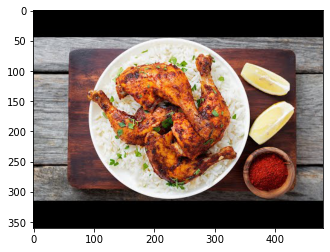

In [67]:
plt.imshow(get_img(df["id"][1]))

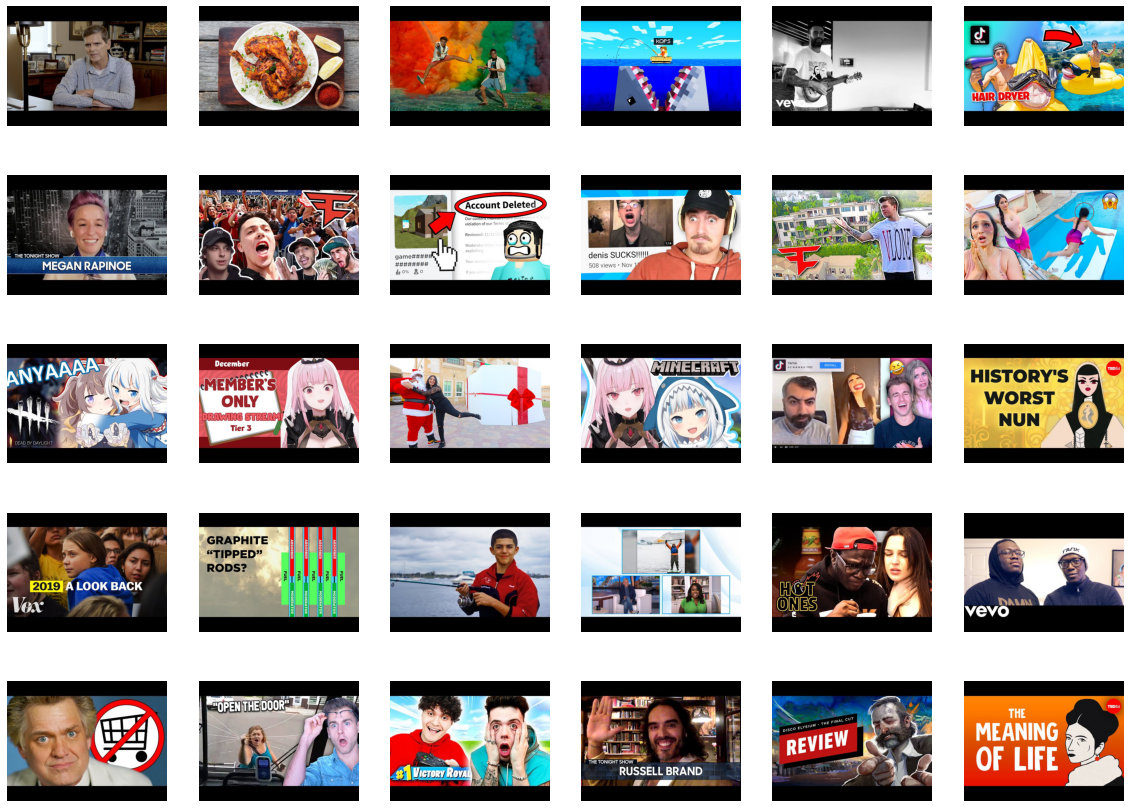

In [68]:
fig,axs=plt.subplots(5,6,figsize=(20,15))

for x in axs.ravel():
    x.axis('off')

for i in range(5):
    for j in range(6):
        axs[i,j].imshow(get_img(df["id"][i*6+j]))

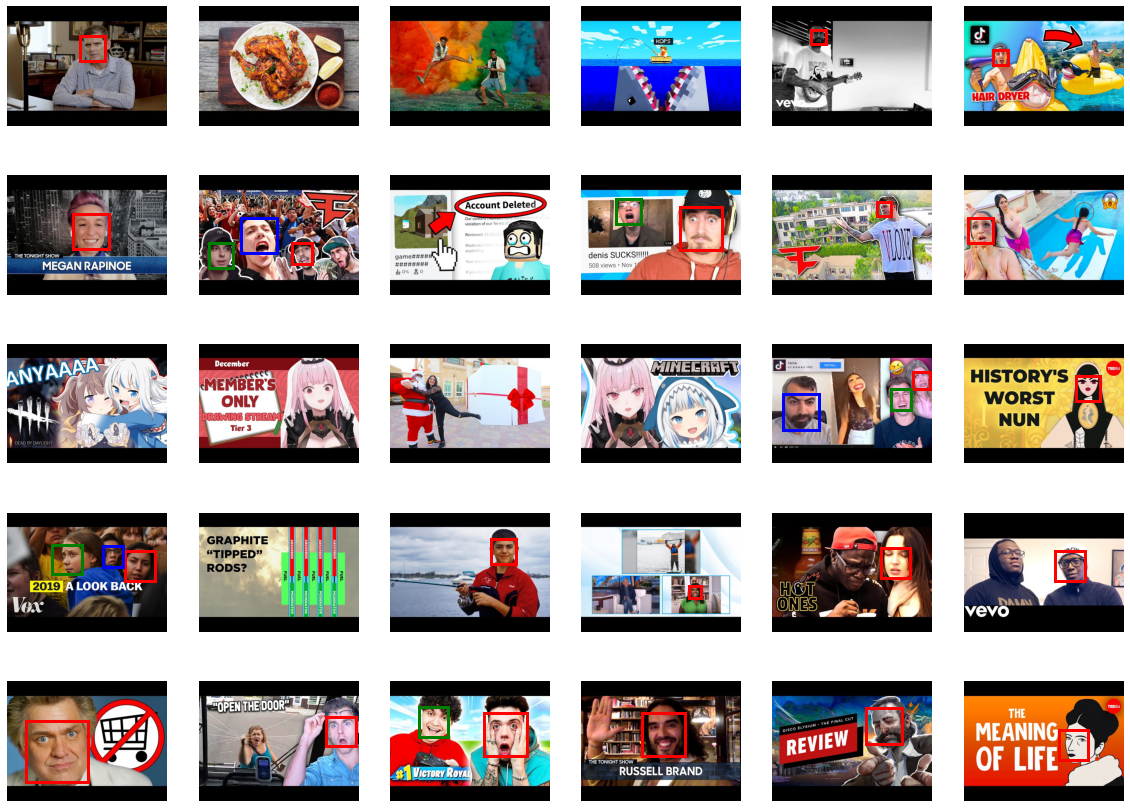

In [69]:
fig,axs=plt.subplots(5,6,figsize=(20,15))

for x in axs.ravel():
    x.axis('off')

for i in range(5):
    for j in range(6):
        img=get_img(df["id"][i*6+j])
        axs[i,j].imshow(img)
        
        locs=face_recognition.face_locations(img)
        
        for x in range(min(3,len(locs))):
            t,r,b,l=locs[x]
            
            rect=patches.Rectangle((l,t),r-l,b-t,linewidth=3,edgecolor="rgb"[x],facecolor='none')
            axs[i,j].add_patch(rect)

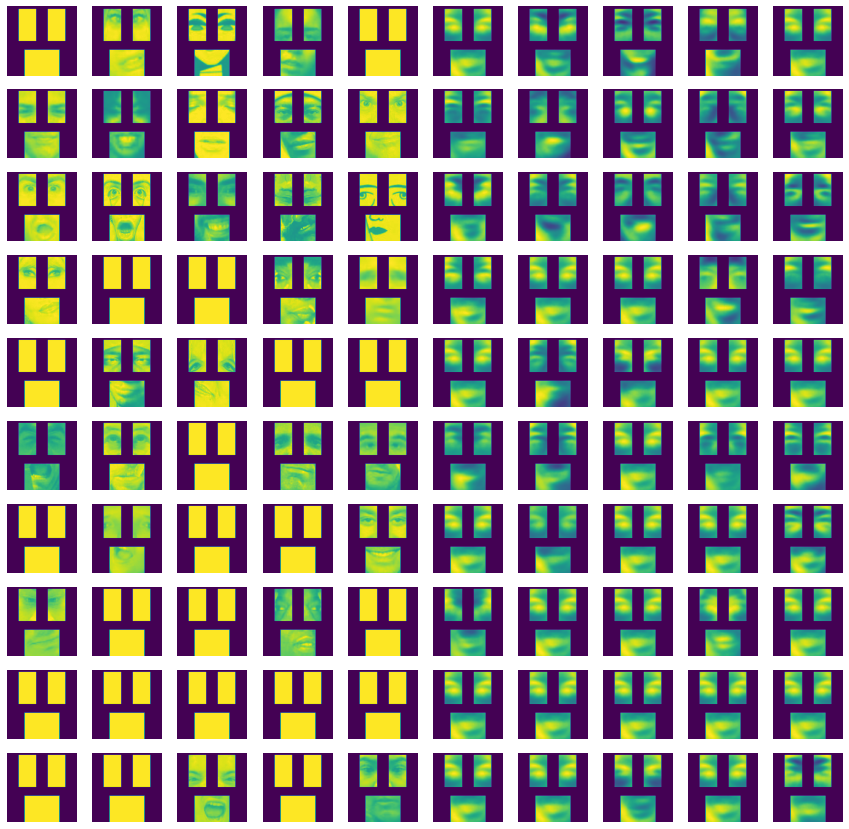

In [70]:
fig,axs=plt.subplots(10,10,figsize=(15,15))

for x in axs.ravel():
    x.axis('off')

for i in range(50):
    img=get_face(df["id"][i+15],0)[:,:,0]
    img=cv2.resize(img,(96,96))
    img=img/256
    img+=0.5+img.mean()

    face_i=np.zeros((96,96))
    face=np.zeros((96,96))

    eye_i=img[4:48,56:80]
    face_i[4:48,56:80]=eye_i
    face_i[4:48,96-80:96-56]=eye_i[:,::-1]

    eye=conv_eye.predict(eye_i.reshape(1,44*24))[0].reshape(44,24)
    face[4:48,56:80]=eye
    face[4:48,96-80:96-56]=eye[:,::-1]


    mouth_i=img[60:96,24:72]
    face_i[60:96,24:72]=mouth_i

    mouth=conv_mouth.predict(mouth_i.reshape(1,36*48))[0].reshape(36,48)
    face[60:96,24:72]=mouth


    axs[i//5][i%5].imshow(face_i)
    axs[i//5][i%5+5].imshow(face)

In [172]:
def get_io(s):
    thumb=[]
    face=[]
    ans=[]

    for id in s:
        img=get_img(id)[44:314]
        thumb.append(img)
        
        img=get_face(id,0)[:,:,0]
        img=cv2.resize(img,(96,96))
        img=img/256
        img+=0.5+img.mean()

        eye=img[4:48,56:80]
        face.append(encode_eye(eye.reshape(1,44*24)))

        mouth=img[60:96,24:72]
        face.append(encode_mouth(mouth.reshape(1,36*48)))
        
        ans.append(df_m["clickbait"][id])
        
    X={
        "thumb":np.array(thumb),
        "face":np.array(face).reshape(-1,32)
    }
    
    y=np.array(ans).reshape(-1,1).astype(int)
    
    return X,y

In [162]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [163]:
X_test,y_test=get_io(s2)

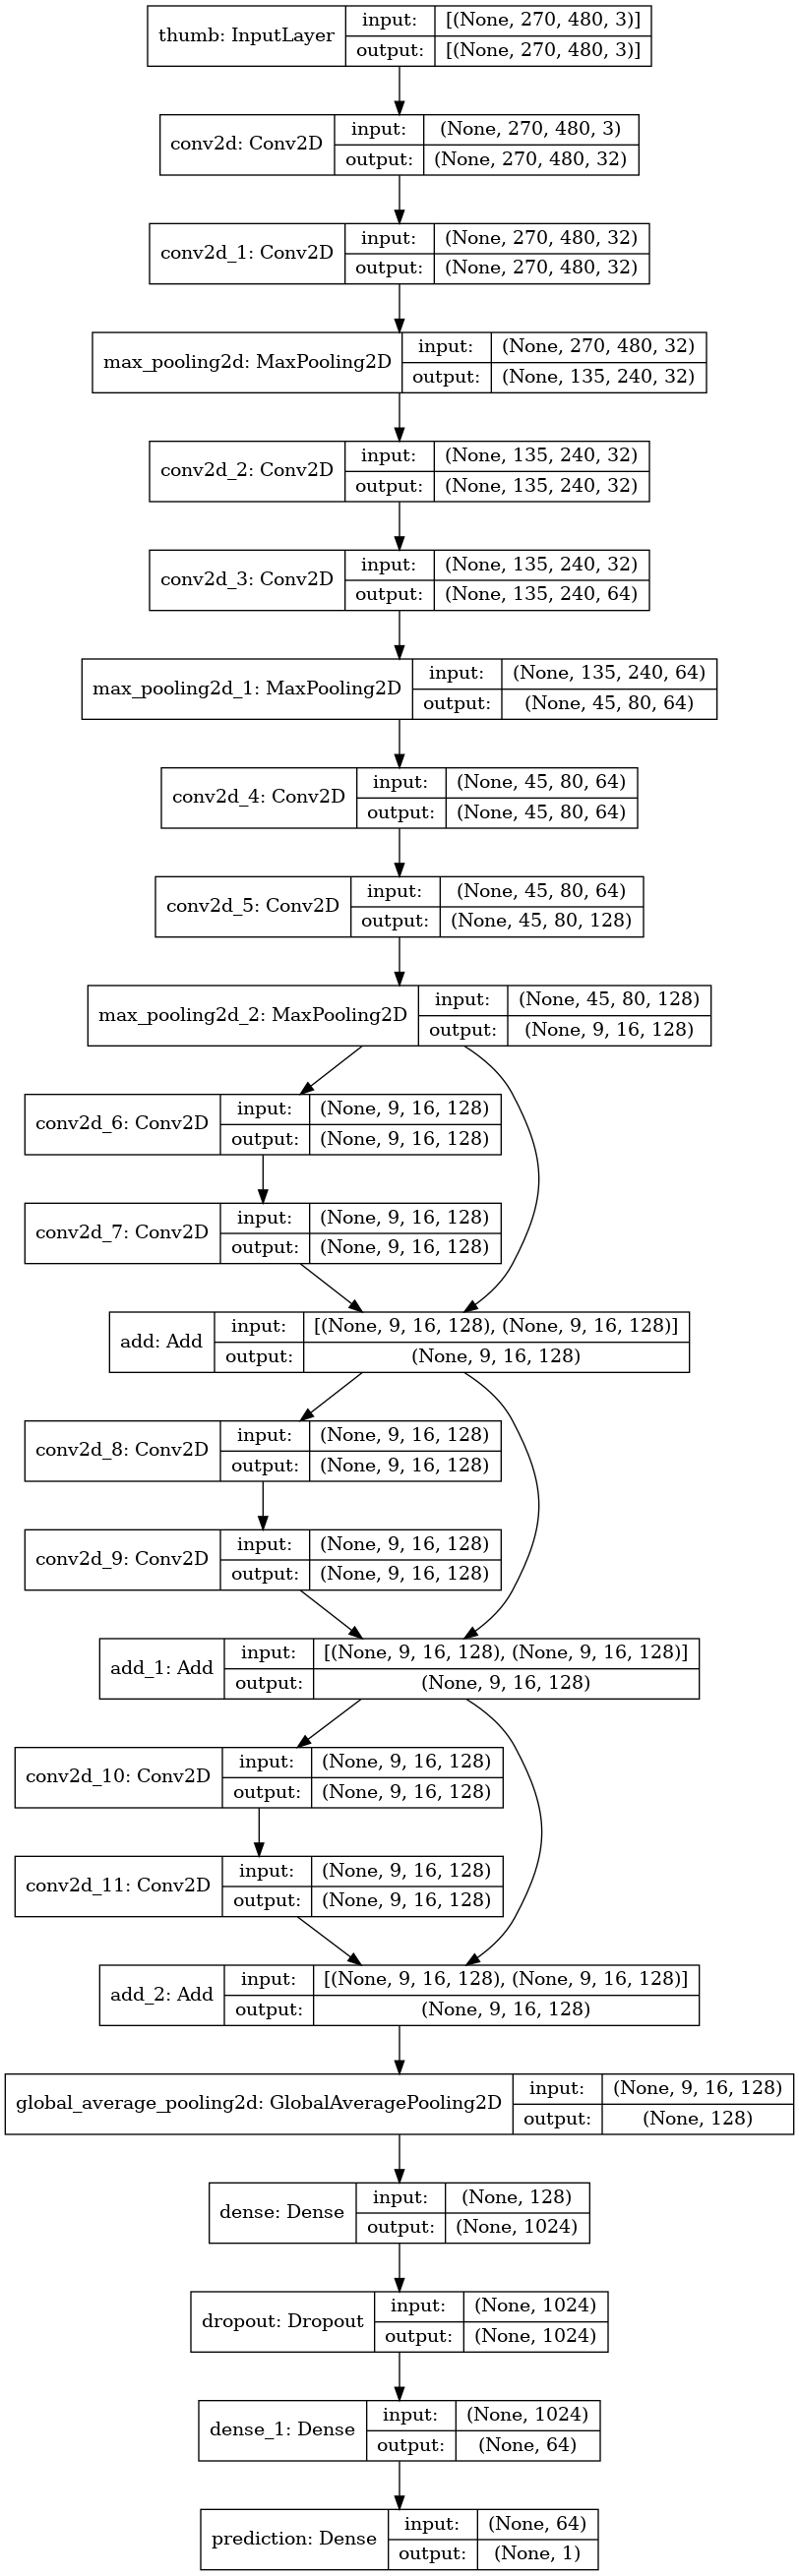

In [189]:
thumbnail_input=keras.Input(shape=(270,480,3),name='thumb')

#2d conv for thumbnail
conv0_thumb=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(thumbnail_input)
conv1_thumb=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(conv0_thumb)
pool=layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv1_thumb)

conv0_thumb=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(pool)
conv1_thumb=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(conv0_thumb)
pool=layers.MaxPooling2D(pool_size=(3,3),strides=(3,3))(conv1_thumb)

conv0_thumb=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(pool)
conv1_thumb=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(conv0_thumb)
pool=layers.MaxPooling2D(pool_size=(5,5),strides=(5,5))(conv1_thumb)

x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(pool)
x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(x)
block0_thumb=layers.add([x,pool])

x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(block0_thumb)
x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(x)
block1_thumb=layers.add([x,block0_thumb])

x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(block1_thumb)
x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(x)
block2_thumb=layers.add([x,block1_thumb])

flat=layers.GlobalAveragePooling2D()(block2_thumb)

dense0=layers.Dense(1024,activation='relu')(flat)
dropout=layers.Dropout(rate=0.5)(dense0)
dense1=layers.Dense(64,activation='relu')(dropout)
pred=layers.Dense(1,activation='sigmoid',name="prediction")(dense1)

model = keras.Model(
    inputs=[thumbnail_input],
    outputs=pred,
)

plot_model(model,show_layer_names=1,show_shapes=True)

In [190]:
model.compile(
  optimizer="adam",
  loss="binary_crossentropy",
  metrics=[f1_m]
)

In [176]:
ids=pd.concat([s3,s])
weights=np.array([10]*len(s3)+[1]*len(s))
X_train,y_train=get_io(ids)

tf.keras.backend.clear_session()
model.fit(X_train["thumb"],y_train,validation_data=(X_test["thumb"],y_test),sample_weight=weights,
              epochs=10,batch_size=8)

Epoch 1/10
1239/1239 [==============================] - 70s 56ms/step - loss: 0.7083 - f1_m: 0.3753 - val_loss: 0.5793 - val_f1_m: 0.4177
Epoch 2/10
1239/1239 [==============================] - 72s 58ms/step - loss: 0.6416 - f1_m: 0.5155 - val_loss: 0.6025 - val_f1_m: 0.4284
Epoch 3/10
1239/1239 [==============================] - 70s 57ms/step - loss: 0.5812 - f1_m: 0.6061 - val_loss: 0.5500 - val_f1_m: 0.4530
Epoch 4/10
1239/1239 [==============================] - 71s 57ms/step - loss: 0.5934 - f1_m: 0.6044 - val_loss: 0.5764 - val_f1_m: 0.4230
Epoch 5/10
1239/1239 [==============================] - 70s 57ms/step - loss: 0.5287 - f1_m: 0.6760 - val_loss: 0.5675 - val_f1_m: 0.4174
Epoch 6/10
1239/1239 [==============================] - 69s 56ms/step - loss: 0.5553 - f1_m: 0.6449 - val_loss: 0.7995 - val_f1_m: 0.4735
Epoch 7/10
1239/1239 [==============================] - 71s 57ms/step - loss: 0.5166 - f1_m: 0.6908 - val_loss: 0.5864 - val_f1_m: 0.3464
Epoch 8/10
1239/1239 [============

In [181]:
ids=pd.concat([s3,s])
weights=np.array([3]*len(s3)+[1]*len(s))
X_train,y_train=get_io(ids)

tf.keras.backend.clear_session()
model.fit(X_train["thumb"],y_train,validation_data=(X_test["thumb"],y_test),sample_weight=weights,
              epochs=10,batch_size=8)

Epoch 1/10
1239/1239 [==============================] - 72s 58ms/step - loss: 0.7870 - f1_m: 0.0422 - val_loss: 0.6321 - val_f1_m: 0.0000e+00
Epoch 2/10
1239/1239 [==============================] - 75s 60ms/step - loss: 0.6892 - f1_m: 0.0018 - val_loss: 0.6410 - val_f1_m: 0.0000e+00
Epoch 3/10
1239/1239 [==============================] - 70s 56ms/step - loss: 0.6688 - f1_m: 0.2157 - val_loss: 0.6261 - val_f1_m: 0.3972
Epoch 4/10
1239/1239 [==============================] - 66s 53ms/step - loss: 0.6432 - f1_m: 0.4272 - val_loss: 0.6038 - val_f1_m: 0.0409
Epoch 5/10
1239/1239 [==============================] - 67s 54ms/step - loss: 0.6134 - f1_m: 0.5158 - val_loss: 0.7239 - val_f1_m: 0.4522
Epoch 6/10
1239/1239 [==============================] - 67s 54ms/step - loss: 0.5550 - f1_m: 0.5989 - val_loss: 0.7321 - val_f1_m: 0.4745
Epoch 7/10
1239/1239 [==============================] - 68s 55ms/step - loss: 0.5188 - f1_m: 0.6769 - val_loss: 0.6667 - val_f1_m: 0.4439
Epoch 8/10
1239/1239 [====

In [191]:
X_train,y_train=get_io(s[:1000])

tf.keras.backend.clear_session()
model.fit(X_train["thumb"],y_train,validation_split=0.2,
              epochs=20,batch_size=8)

Epoch 1/20
100/100 [==============================] - 6s 60ms/step - loss: 1.6240 - f1_m: 0.2306 - val_loss: 0.6913 - val_f1_m: 0.4386
Epoch 2/20
100/100 [==============================] - 6s 57ms/step - loss: 0.6895 - f1_m: 0.0299 - val_loss: 0.6914 - val_f1_m: 0.0000e+00
Epoch 3/20
100/100 [==============================] - 6s 58ms/step - loss: 0.6887 - f1_m: 0.0000e+00 - val_loss: 0.7061 - val_f1_m: 0.0000e+00
Epoch 4/20
100/100 [==============================] - 6s 58ms/step - loss: 0.6860 - f1_m: 0.0000e+00 - val_loss: 0.7271 - val_f1_m: 0.0000e+00
Epoch 5/20
100/100 [==============================] - 6s 58ms/step - loss: 0.6956 - f1_m: 0.0838 - val_loss: 0.6816 - val_f1_m: 0.0000e+00
Epoch 6/20
100/100 [==============================] - 6s 59ms/step - loss: 0.6576 - f1_m: 0.1660 - val_loss: 0.6863 - val_f1_m: 0.6396
Epoch 7/20
100/100 [==============================] - 6s 58ms/step - loss: 0.6377 - f1_m: 0.4016 - val_loss: 0.6590 - val_f1_m: 0.6785
Epoch 8/20
100/100 [===========

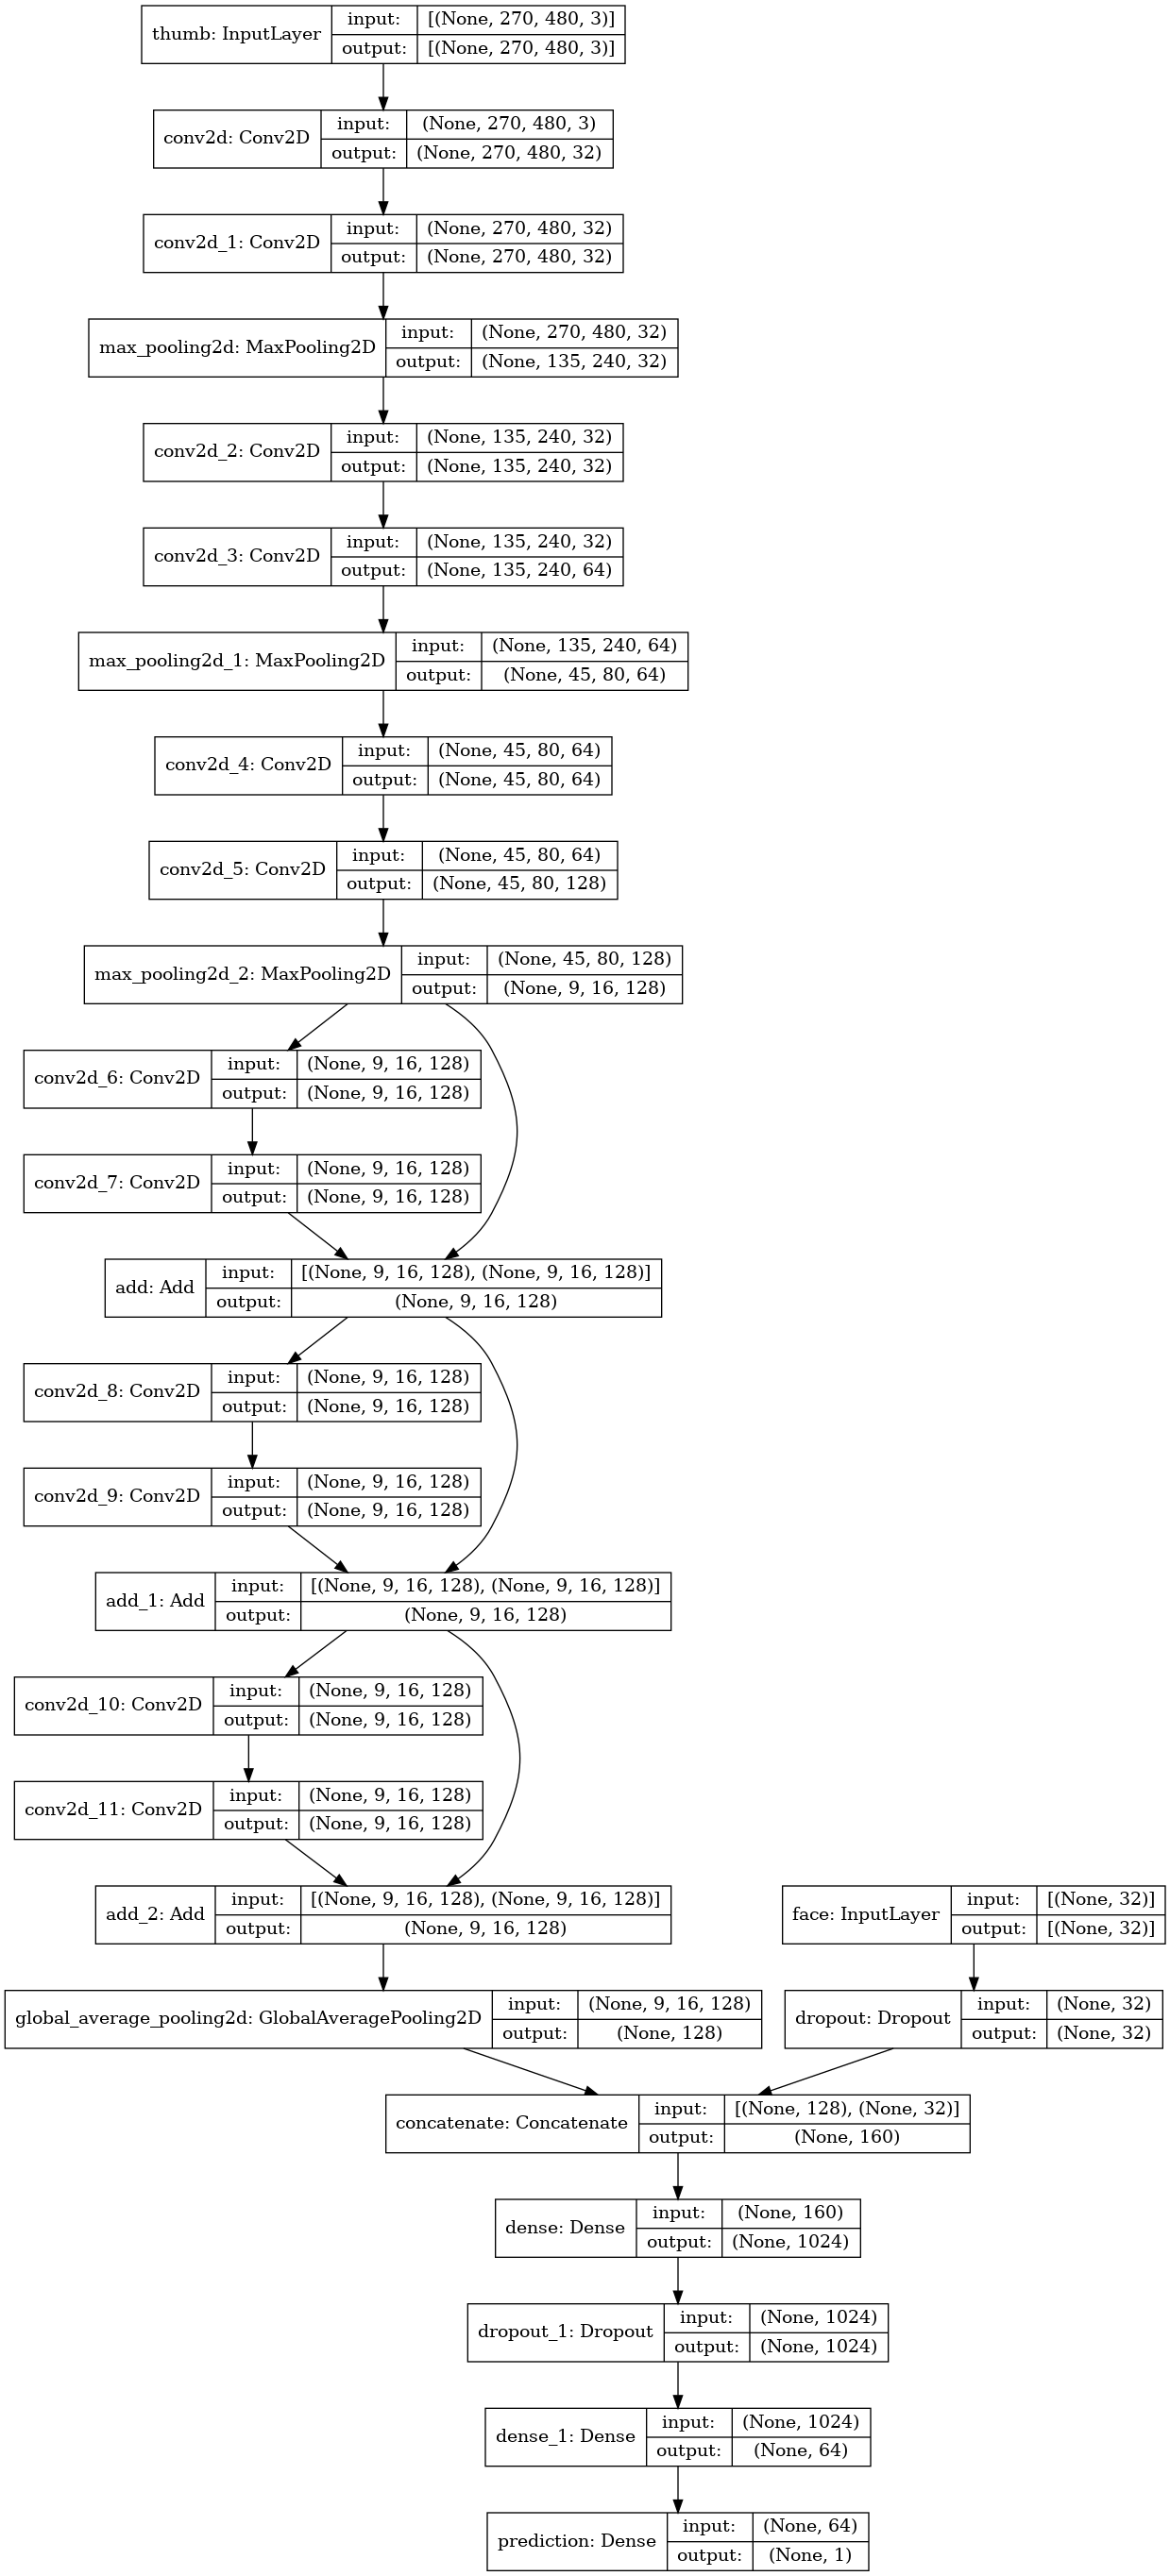

In [192]:
thumbnail_input=keras.Input(shape=(270,480,3),name='thumb') #all thumbnails have size 360x480

#2d conv for thumbnail
conv0_thumb=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(thumbnail_input)
conv1_thumb=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(conv0_thumb)
pool=layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv1_thumb)

conv0_thumb=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(pool)
conv1_thumb=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(conv0_thumb)
pool=layers.MaxPooling2D(pool_size=(3,3),strides=(3,3))(conv1_thumb)

conv0_thumb=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(pool)
conv1_thumb=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(conv0_thumb)
pool=layers.MaxPooling2D(pool_size=(5,5),strides=(5,5))(conv1_thumb)

x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(pool)
x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(x)
block0_thumb=layers.add([x,pool])

x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(block0_thumb)
x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(x)
block1_thumb=layers.add([x,block0_thumb])

x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(block1_thumb)
x=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(x)
block2_thumb=layers.add([x,block1_thumb])

flat=layers.GlobalAveragePooling2D()(block2_thumb)

#face inputs
face_input=keras.Input(shape=(32),name="face")
dropout=layers.Dropout(rate=0.5)(face_input)
    
concat=layers.concatenate([flat,dropout])

dense0=layers.Dense(1024,activation='relu')(concat)
dropout=layers.Dropout(rate=0.5)(dense0)
dense1=layers.Dense(64,activation='relu')(dropout)
pred=layers.Dense(1,activation='sigmoid',name="prediction")(dense1)

model = keras.Model(
    inputs=[thumbnail_input,face_input],
    outputs=pred,
)

plot_model(model,show_layer_names=1,show_shapes=True)

In [193]:
model.compile(
  optimizer="adam",
  loss="binary_crossentropy",
  metrics=[f1_m]
)

In [28]:
tf.keras.backend.clear_session()
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=8) #double block

Epoch 1/10
1218/1218 [==============================] - 66s 54ms/step - loss: 1.0647 - f1_m: 0.2486 - val_loss: 0.6862 - val_f1_m: 0.4098
Epoch 2/10
1218/1218 [==============================] - 65s 54ms/step - loss: 0.6507 - f1_m: 0.4274 - val_loss: 0.5702 - val_f1_m: 0.4424
Epoch 3/10
1218/1218 [==============================] - 67s 55ms/step - loss: 0.5844 - f1_m: 0.5453 - val_loss: 0.5525 - val_f1_m: 0.3432
Epoch 4/10
1218/1218 [==============================] - 67s 55ms/step - loss: 0.5455 - f1_m: 0.5809 - val_loss: 0.6020 - val_f1_m: 0.4052
Epoch 5/10
1218/1218 [==============================] - 67s 55ms/step - loss: 0.5254 - f1_m: 0.6332 - val_loss: 0.5758 - val_f1_m: 0.4461
Epoch 6/10
1218/1218 [==============================] - 69s 56ms/step - loss: 0.4631 - f1_m: 0.7035 - val_loss: 0.5734 - val_f1_m: 0.5137
Epoch 7/10
1218/1218 [==============================] - 66s 54ms/step - loss: 0.4257 - f1_m: 0.7294 - val_loss: 0.6434 - val_f1_m: 0.5061
Epoch 8/10
1218/1218 [============

In [194]:
X_train,y_train=get_io(s[:1000])

tf.keras.backend.clear_session()
model.fit(X_train,y_train,validation_split=0.2,
              epochs=20,batch_size=8)

Epoch 1/20
100/100 [==============================] - 6s 58ms/step - loss: 1.3747 - f1_m: 0.2987 - val_loss: 0.6981 - val_f1_m: 0.0000e+00
Epoch 2/20
100/100 [==============================] - 6s 58ms/step - loss: 0.6815 - f1_m: 0.0367 - val_loss: 0.6915 - val_f1_m: 0.3106
Epoch 3/20
100/100 [==============================] - 6s 59ms/step - loss: 0.6985 - f1_m: 0.2885 - val_loss: 0.6960 - val_f1_m: 0.0160
Epoch 4/20
100/100 [==============================] - 6s 59ms/step - loss: 0.6844 - f1_m: 0.1515 - val_loss: 0.6911 - val_f1_m: 0.0453
Epoch 5/20
100/100 [==============================] - 6s 59ms/step - loss: 0.6658 - f1_m: 0.2726 - val_loss: 0.7193 - val_f1_m: 0.0474
Epoch 6/20
100/100 [==============================] - 6s 59ms/step - loss: 0.6406 - f1_m: 0.3920 - val_loss: 0.6946 - val_f1_m: 0.0827
Epoch 7/20
100/100 [==============================] - 6s 59ms/step - loss: 0.6787 - f1_m: 0.2566 - val_loss: 0.7598 - val_f1_m: 0.0274
Epoch 8/20
100/100 [==============================]

In [32]:
lol=model.predict(X_train)

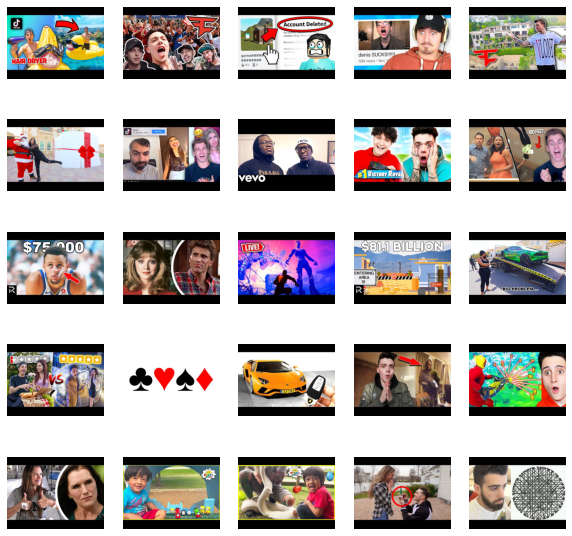

In [34]:
fig,axs=plt.subplots(5,5,figsize=(10,10))

for x in axs.ravel():
    x.axis("off")

curr=0
for i in range(1000):
    if (lol[i]>0.95):
        axs[curr//5][curr%5].imshow(get_img(df["id"][i]))
        curr+=1
        
        if(curr==25): break

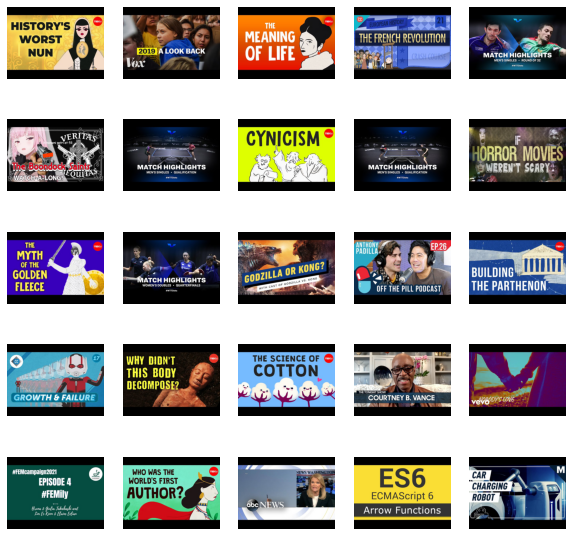

In [33]:
fig,axs=plt.subplots(5,5,figsize=(10,10))

for x in axs.ravel():
    x.axis("off")

curr=0
for i in range(1000):
    if (lol[i]<0.05):
        axs[curr//5][curr%5].imshow(get_img(df["id"][i]))
        curr+=1
        
        if(curr==25): break